In [1]:
import torch as pt

mols_test = pt.load('./data/mine/test_11499.pt')
print(len(mols_test))
mols_test_rep = pt.load('./data/mine/test_11499_rep.pt')
print(len(mols_test_rep))
mols_all = pt.load('./data/mine/mols_all.pt')
print(len(mols_all))

11499
11499
2253216


In [2]:
from torch.utils.data import DataLoader
from utils.data import SpecDataset, collate_fun_emb


dataset_test = SpecDataset(mols_test)
loader_test = DataLoader(dataset_test, batch_size=2048, shuffle=False,
                        num_workers=8, collate_fn=collate_fun_emb)
dataset_lib = SpecDataset(mols_all)
loader_lib = DataLoader(dataset_lib, batch_size=2048, shuffle=False,
                        num_workers=8, collate_fn=collate_fun_emb)
dataset_test_rep = SpecDataset(mols_test_rep)
loader_test_rep = DataLoader(dataset_test_rep, batch_size=2048, shuffle=False,
                        num_workers=8, collate_fn=collate_fun_emb)

In [3]:
from utils.model import Spec2Emb

gpu=6
model = Spec2Emb().to(gpu)
model.load_state_dict(pt.load('./model/mass_before_ft_p0.4_epoch2.pth', map_location='cpu'))

<All keys matched successfully>

In [4]:
from utils.data import gen_embeddings


embs_lib = gen_embeddings(model, loader_lib, gpu, power=0.4)
embs_test = gen_embeddings(model, loader_test, gpu, power=0.4)
embs_test_rep = gen_embeddings(model, loader_test_rep, gpu, power=0.4)

In [5]:
import numpy as np
from utils.data import faiss_idx


index_flat = faiss_idx(embs_lib[:2146690], gpu)
_, I_test = index_flat.search(embs_test, 200)
_, I_test_rep = index_flat.search(embs_test_rep, 200)

In [9]:
import torch as pt
from utils.tools import hit_rate_topk


top10_hit_test = hit_rate_topk(mols_test, I_test, mols_all, topk=10, step=1)
top10_hit_test_rep = hit_rate_topk(mols_test_rep, I_test_rep, mols_all, topk=10, step=1)
top100_hit_test = hit_rate_topk(mols_test, I_test, mols_all)
top100_hit_test_rep = hit_rate_topk(mols_test_rep, I_test_rep, mols_all)

In [10]:
top1_10_100_hit_test = pt.cat([top10_hit_test, top100_hit_test[1:]])[None,:]
top1_10_100_hit_test_rep = pt.cat([top10_hit_test_rep, top100_hit_test_rep[1:]])[None,:]
top1_10_100_hit = pt.cat([top1_10_100_hit_test, top1_10_100_hit_test_rep], dim=0)
print(top1_10_100_hit)
pt.save(top1_10_100_hit, './data/mine/top1_10_100_finetune_0.4_200.pt')

tensor([[0.4361, 0.6071, 0.6879, 0.7380, 0.7699, 0.7930, 0.8113, 0.8256, 0.8360,
         0.8451, 0.8941, 0.9136, 0.9270, 0.9348, 0.9407, 0.9449, 0.9480, 0.9509,
         0.9530],
        [0.3982, 0.5641, 0.6478, 0.7019, 0.7337, 0.7585, 0.7766, 0.7933, 0.8075,
         0.8164, 0.8713, 0.8962, 0.9106, 0.9200, 0.9273, 0.9323, 0.9370, 0.9402,
         0.9427]])


In [1]:
import torch as pt 

top1_10_100_hit = pt.load('./data/mine/top1_10_100_finetune_0.4_200.pt')
print(top1_10_100_hit)

tensor([[0.4361, 0.6071, 0.6879, 0.7380, 0.7699, 0.7930, 0.8113, 0.8256, 0.8360,
         0.8451, 0.8941, 0.9136, 0.9270, 0.9348, 0.9407, 0.9449, 0.9480, 0.9509,
         0.9530],
        [0.3982, 0.5641, 0.6478, 0.7019, 0.7337, 0.7585, 0.7766, 0.7933, 0.8075,
         0.8164, 0.8713, 0.8962, 0.9106, 0.9200, 0.9273, 0.9323, 0.9370, 0.9402,
         0.9427]])


In [2]:
top1_10_100_hit_fastei = pt.load('./data/mine/top1_10_100_hit_fastei.pt')
print(top1_10_100_hit_fastei)

tensor([[0.3686, 0.5352, 0.6230, 0.6775, 0.7143, 0.7421, 0.7636, 0.7790, 0.7922,
         0.8042, 0.8631, 0.8888, 0.9039, 0.9137, 0.9206, 0.9273, 0.9323, 0.9358,
         0.9396],
        [0.3457, 0.5073, 0.5962, 0.6537, 0.6877, 0.7161, 0.7373, 0.7555, 0.7704,
         0.7822, 0.8449, 0.8746, 0.8910, 0.9015, 0.9108, 0.9165, 0.9212, 0.9257,
         0.9294]])


In [3]:
print((top1_10_100_hit[1] - top1_10_100_hit_fastei[0]).mean())

tensor(0.0132)


In [12]:
from matplotlib import pyplot as plt

x_axis = np.arange(1,10).tolist() + np.arange(10, 101, 10).tolist()
print(x_axis)
top1_10_100_hit_fastei = pt.load('./data/mine/top1_10_100_hit_fastei.pt')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


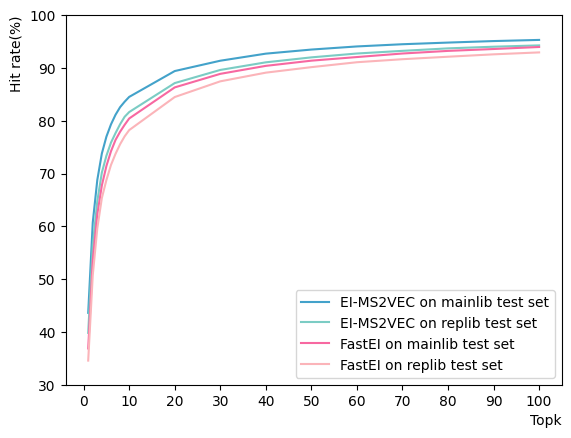

In [32]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_axis, 100*top1_10_100_hit[0], label='EI-MS2VEC on mainlib test set', color='#43a2ca')
ax.plot(x_axis, 100*top1_10_100_hit[1], label='EI-MS2VEC on replib test set', color='#7bccc4')
ax.plot(x_axis, 100*top1_10_100_hit_fastei[0], label='FastEI on mainlib test set', color='#f768a1')
ax.plot(x_axis, 100*top1_10_100_hit_fastei[1], label='FastEI on replib test set', color='#fbb4b9')
ax.set_xticks(np.arange(0, 101, 10))
ax.set_yticks(np.arange(30, 101, 10))
ax.set_xlabel('Topk', loc='right')
ax.set_ylabel('Hit rate(%)', loc='top')
ax.legend()
fig.savefig('./picture/robus.svg', format='svg', dpi=500)

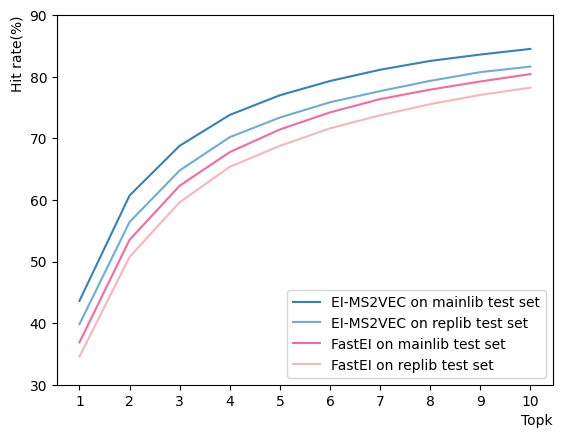

: 

In [33]:
fig1 = plt.figure()
ax1 = fig1.add_subplot()
ax1.plot(x_axis[:10], 100*top1_10_100_hit[0][:10], label='EI-MS2VEC on mainlib test set', color='#3182bd')
ax1.plot(x_axis[:10], 100*top1_10_100_hit[1][:10], label='EI-MS2VEC on replib test set', color='#6baed6')
ax1.plot(x_axis[:10], 100*top1_10_100_hit_fastei[0][:10], label='FastEI on mainlib test set', color='#f768a1')
ax1.plot(x_axis[:10], 100*top1_10_100_hit_fastei[1][:10], label='FastEI on replib test set', color='#fbb4b9')
ax1.set_xticks(x_axis[:10])
ax1.set_yticks(np.arange(30, 91, 10))
ax1.set_xlabel('Topk', loc='right')
ax1.set_ylabel('Hit rate(%)', loc='top')
ax1.legend()
fig1.savefig('./picture/robus_top10.svg', format='svg', dpi=500)